In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.model_selection import train_test_split
import warnings

warnings.filterwarnings('ignore')

In [ ]:
!apt-get install rsync


Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
rsync is already the newest version (3.2.7-0ubuntu0.22.04.2).
0 upgraded, 0 newly installed, 0 to remove and 49 not upgraded.


In [ ]:
# Define source and destination directories
SOURCE_DIR='/content/drive/MyDrive/mlolympiads24/'
DEST_DIR='/content/mlolympiads24/'

# Create destination directories
!mkdir -p $DEST_DIR

# Use rsync to copy files recursively and preserve permissions
!rsync -av --progress $SOURCE_DIR $DEST_DIR


sending incremental file list

sent 2,499,245 bytes  received 23 bytes  39,358.55 bytes/sec
total size is 9,316,569,558  speedup is 3,727.72


In [ ]:
BASE_DIR = '/content/mlolympiads24'

TRAIN_IMAGE_DIR = os.path.join(BASE_DIR, 'train')
TRAIN_LABEL_DIR = os.path.join(BASE_DIR, 'train_labels')
TEST_IMAGE_DIR = os.path.join(BASE_DIR, 'test')

print("Train Image Directory Exists:", os.path.exists(TRAIN_IMAGE_DIR))
print("Train Label Directory Exists:", os.path.exists(TRAIN_LABEL_DIR))
print("Test Image Directory Exists:", os.path.exists(TEST_IMAGE_DIR))

train_files = os.listdir(TRAIN_IMAGE_DIR)
print(f"Number of files in {TRAIN_IMAGE_DIR}: {len(train_files)}")
print("Sample files:", train_files[:10])

label_files = os.listdir(TRAIN_LABEL_DIR)
print(f"Number of files in {TRAIN_LABEL_DIR}: {len(label_files)}")
print("Sample label files:", label_files[:10])

test_files = os.listdir(TEST_IMAGE_DIR)
print(f"Number of files in {TEST_IMAGE_DIR}: {len(test_files)}")
print("Sample test files:", test_files[:10])



Train Image Directory Exists: True
Train Label Directory Exists: True
Test Image Directory Exists: True
Number of files in /content/mlolympiads24/train: 72079
Sample files: ['193_5632_6400.png', '193_5632_6656.png', '193_5632_6912.png', '193_5632_7168.png', '193_5632_7424.png', '193_5632_7680.png', '193_5632_7936.png', '193_5632_8192.png', '193_5632_8448.png', '193_5632_8704.png']
Number of files in /content/mlolympiads24/train_labels: 72079
Sample label files: ['193_5632_5632.png', '193_5632_5888.png', '193_5632_6144.png', '193_5632_6400.png', '193_5632_6656.png', '193_5632_6912.png', '193_5632_7168.png', '193_5632_7424.png', '193_5632_7680.png', '193_5632_7936.png']
Number of files in /content/mlolympiads24/test: 29243
Sample test files: ['102_3840_5376.png', '102_3840_5632.png', '102_3840_5888.png', '102_3840_6144.png', '102_3840_6400.png', '102_3840_6656.png', '102_3840_6912.png', '102_3840_7168.png', '102_3840_7424.png', '102_3840_7680.png']


In [ ]:
IMG_HEIGHT = 256
IMG_WIDTH = 256
IMG_CHANNELS = 3
BATCH_SIZE = 64


In [ ]:
train_image_files = tf.data.Dataset.list_files(os.path.join(TRAIN_IMAGE_DIR, '*.png'), shuffle=False)
train_label_files = tf.data.Dataset.list_files(os.path.join(TRAIN_LABEL_DIR, '*.png'), shuffle=False)
test_image_files = tf.data.Dataset.list_files(os.path.join(TEST_IMAGE_DIR, '*.png'), shuffle=False)

total_images = 10000

train_image_files = train_image_files.take(total_images)
train_label_files = train_label_files.take(total_images)

In [ ]:
num_train_images = tf.data.experimental.cardinality(train_image_files).numpy()
num_train_labels = tf.data.experimental.cardinality(train_label_files).numpy()
num_test_images = tf.data.experimental.cardinality(test_image_files).numpy()

print(f"Number of training images: {num_train_images}")
print(f"Number of training masks: {num_train_labels}")
print(f"Number of test images: {num_test_images}")


Number of training images: 10000
Number of training masks: 10000
Number of test images: 29243


In [ ]:
full_dataset = tf.data.Dataset.zip((train_image_files, train_label_files))

full_dataset = full_dataset.shuffle(buffer_size=1000, reshuffle_each_iteration=False)

dataset_size = num_train_images

train_size = int(0.8 * total_images)
val_size = total_images - train_size

train_dataset = full_dataset.take(train_size)
val_dataset = full_dataset.skip(train_size)


In [ ]:
def load_image_and_mask(image_path, mask_path):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_png(image, channels=IMG_CHANNELS)
    image = tf.image.resize(image, [IMG_HEIGHT, IMG_WIDTH])
    image = tf.cast(image, tf.float32) / 255.0

    mask = tf.io.read_file(mask_path)
    mask = tf.image.decode_png(mask, channels=1)
    mask = tf.image.resize(mask, [IMG_HEIGHT, IMG_WIDTH])
    mask = tf.cast(mask, tf.float32) / 255.0

    return image, mask


AUTOTUNE = tf.data.experimental.AUTOTUNE

train_dataset = train_dataset.map(load_image_and_mask, num_parallel_calls=AUTOTUNE)
val_dataset = val_dataset.map(load_image_and_mask, num_parallel_calls=AUTOTUNE)

train_dataset = train_dataset.cache()
val_dataset = val_dataset.cache()


train_dataset = train_dataset.batch(BATCH_SIZE)
train_dataset = train_dataset.prefetch(AUTOTUNE)

val_dataset = val_dataset.batch(BATCH_SIZE)
val_dataset = val_dataset.prefetch(AUTOTUNE)




In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (
    Input, Conv2D, MaxPooling2D, Dropout, Conv2DTranspose, concatenate
)

def unet_model(input_size=(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS)):
    inputs = Input(input_size)

    # Encoder
    c1 = Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    c1 = Dropout(0.1)(c1)
    c1 = Conv2D(32, (3, 3), activation='relu', padding='same')(c1)
    p1 = MaxPooling2D((2, 2))(c1)

    c2 = Conv2D(64, (3, 3), activation='relu', padding='same')(p1)
    c2 = Dropout(0.1)(c2)
    c2 = Conv2D(64, (3, 3), activation='relu', padding='same')(c2)
    p2 = MaxPooling2D((2, 2))(c2)

    c3 = Conv2D(128, (3, 3), activation='relu', padding='same')(p2)
    c3 = Dropout(0.2)(c3)
    c3 = Conv2D(128, (3, 3), activation='relu', padding='same')(c3)
    p3 = MaxPooling2D((2, 2))(c3)

    c4 = Conv2D(256, (3, 3), activation='relu', padding='same')(p3)
    c4 = Dropout(0.2)(c4)
    c4 = Conv2D(256, (3, 3), activation='relu', padding='same')(c4)
    p4 = MaxPooling2D(pool_size=(2, 2))(c4)

    # Bottleneck
    c5 = Conv2D(512, (3, 3), activation='relu', padding='same')(p4)
    c5 = Dropout(0.3)(c5)
    c5 = Conv2D(512, (3, 3), activation='relu', padding='same')(c5)

    # Decoder
    u6 = Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(c5)
    u6 = concatenate([u6, c4])
    c6 = Conv2D(256, (3, 3), activation='relu', padding='same')(u6)
    c6 = Dropout(0.2)(c6)
    c6 = Conv2D(256, (3, 3), activation='relu', padding='same')(c6)

    u7 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = concatenate([u7, c3])
    c7 = Conv2D(128, (3, 3), activation='relu', padding='same')(u7)
    c7 = Dropout(0.2)(c7)
    c7 = Conv2D(128, (3, 3), activation='relu', padding='same')(c7)

    u8 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c7)
    u8 = concatenate([u8, c2])
    c8 = Conv2D(64, (3, 3), activation='relu', padding='same')(u8)
    c8 = Dropout(0.1)(c8)
    c8 = Conv2D(64, (3, 3), activation='relu', padding='same')(c8)

    u9 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c8)
    u9 = concatenate([u9, c1])
    c9 = Conv2D(32, (3, 3), activation='relu', padding='same')(u9)
    c9 = Dropout(0.1)(c9)
    c9 = Conv2D(32, (3, 3), activation='relu', padding='same')(c9)

    outputs = Conv2D(1, (1, 1), activation='sigmoid')(c9)

    model = Model(inputs=[inputs], outputs=[outputs])
    return model

model = unet_model()


In [ ]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

earlystopper = EarlyStopping(patience=10, verbose=1, restore_best_weights=True)
checkpoint_filepath = 'model_checkpoint.weights.h5'

checkpointer = ModelCheckpoint(
    filepath=checkpoint_filepath,
    monitor='val_loss',
    verbose=1,
    save_best_only=True,
    save_weights_only=True
)

reduce_lr = ReduceLROnPlateau(factor=0.1, patience=3, min_lr=1e-6, verbose=1)


In [ ]:
EPOCHS = 15
STEPS_PER_EPOCH = 8000 // 32
VALIDATION_STEPS = 2000 // 32

In [ ]:
history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=EPOCHS,
    steps_per_epoch=STEPS_PER_EPOCH,
    validation_steps=VALIDATION_STEPS,
    callbacks=[earlystopper, checkpointer, reduce_lr]
)


model.load_weights(checkpoint_filepath)


Epoch 1/15
125/250 ━━━━━━━━━━━━━━━━━━━━ 18s 150ms/step - accuracy: 0.9825 - loss: 0.0635
Epoch 1: val_loss improved from inf to 0.21008, saving model to model_checkpoint.weights.h5
250/250 ━━━━━━━━━━━━━━━━━━━━ 21s 83ms/step - accuracy: 0.9792 - loss: 0.0706 - val_accuracy: 0.9094 - val_loss: 0.2101 - learning_rate: 0.0010
Epoch 2/15
125/250 ━━━━━━━━━━━━━━━━━━━━ 18s 150ms/step - accuracy: 0.9832 - loss: 0.0596
Epoch 2: val_loss improved from 0.21008 to 0.20402, saving model to model_checkpoint.weights.h5
250/250 ━━━━━━━━━━━━━━━━━━━━ 21s 82ms/step - accuracy: 0.9804 - loss: 0.0651 - val_accuracy: 0.9131 - val_loss: 0.2040 - learning_rate: 0.0010
Epoch 3/15
125/250 ━━━━━━━━━━━━━━━━━━━━ 18s 150ms/step - accuracy: 0.9833 - loss: 0.0595
Epoch 3: val_loss did not improve from 0.20402
250/250 ━━━━━━━━━━━━━━━━━━━━ 20s 81ms/step - accuracy: 0.9801 - loss: 0.0664 - val_accuracy: 0.9101 - val_loss: 0.2148 - learning_rate: 0.0010
Epoch 4/15
125/250 ━━━━━━━━━━━━━━━━━━━━ 18s 149ms/step - accuracy: 0.

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


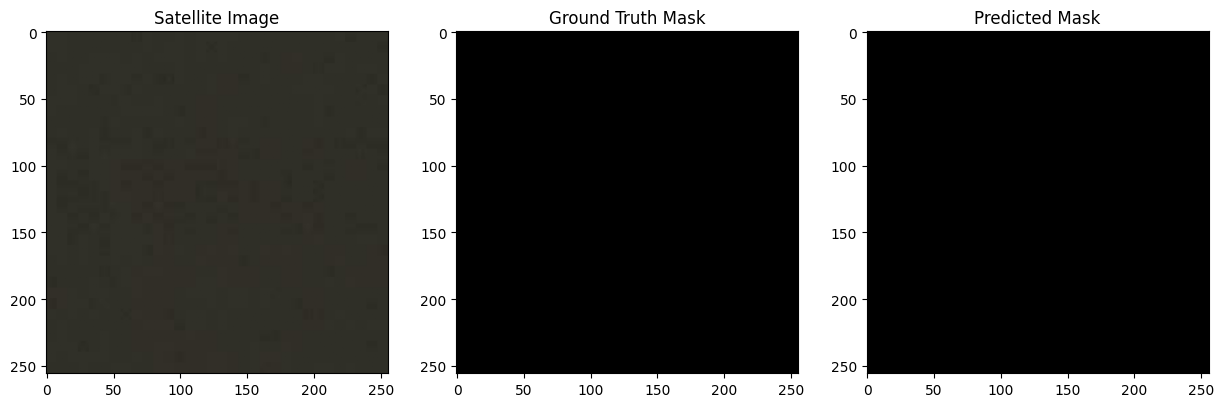

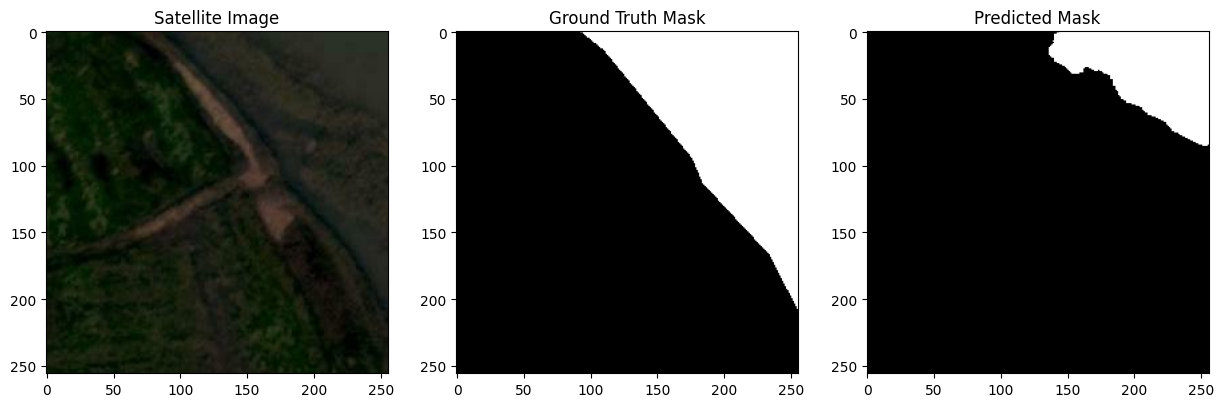

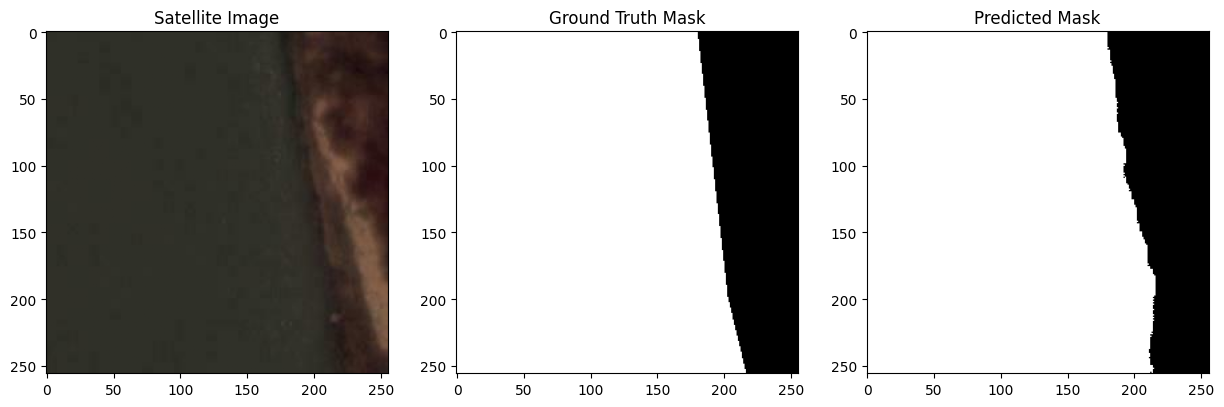

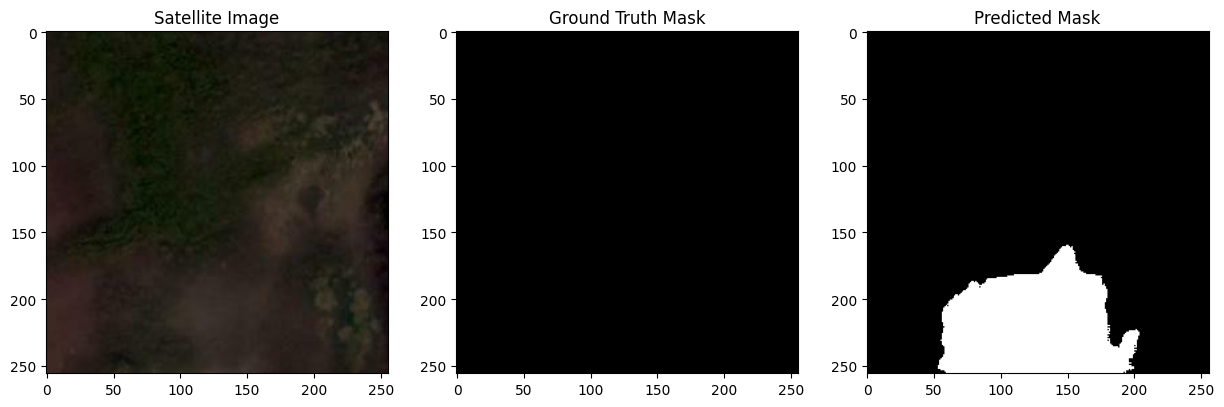

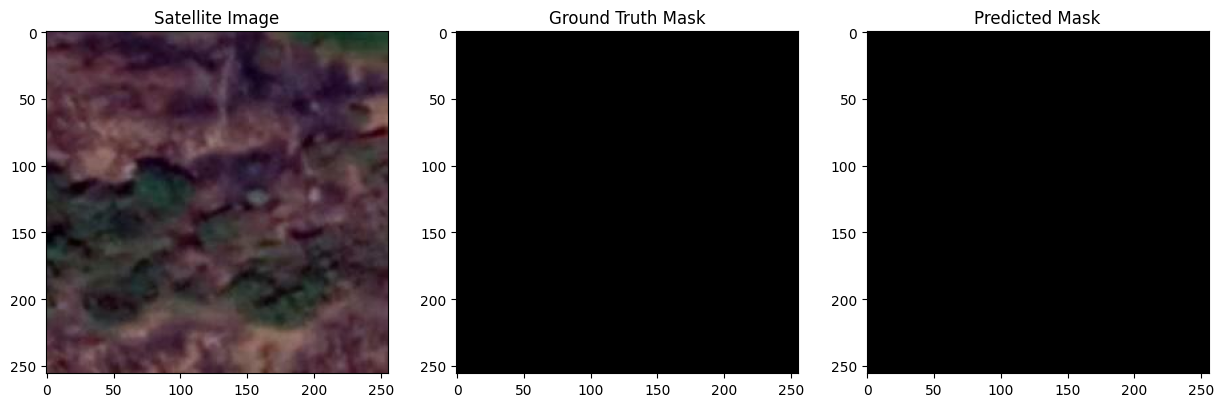

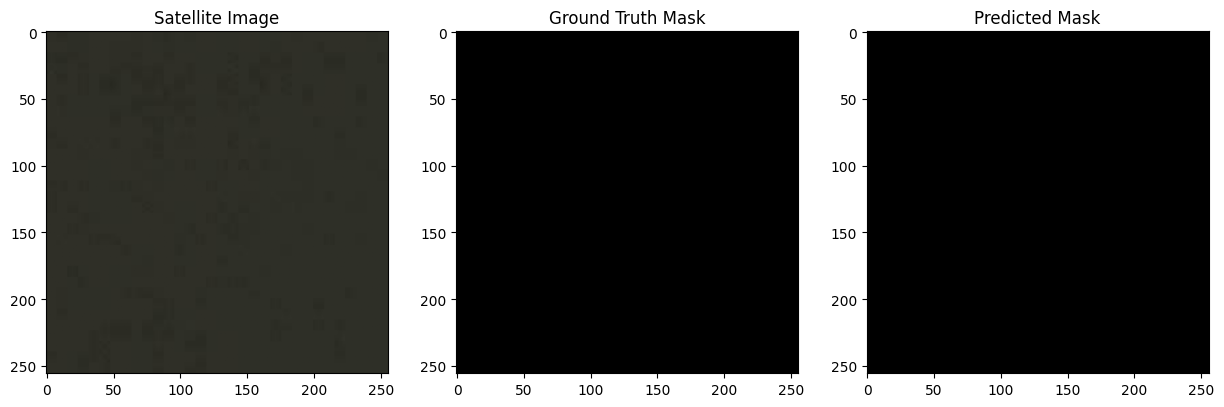

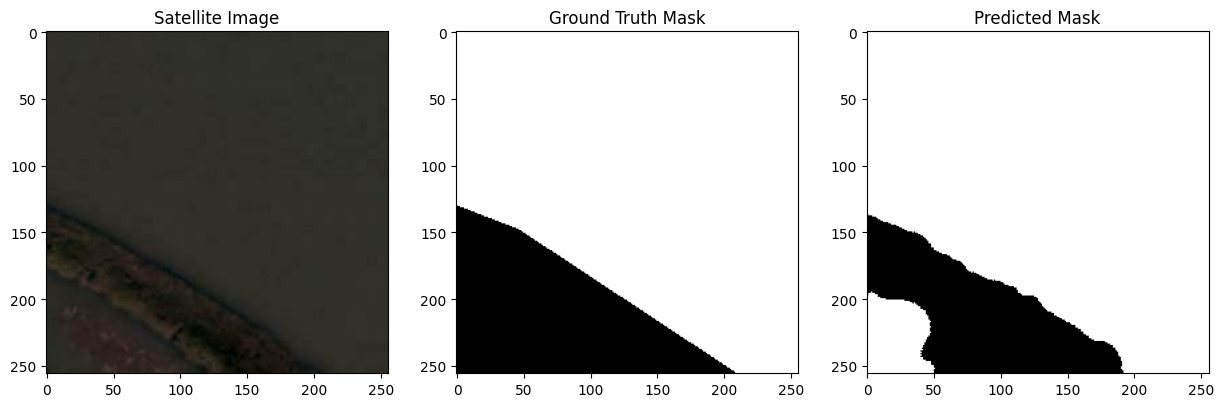

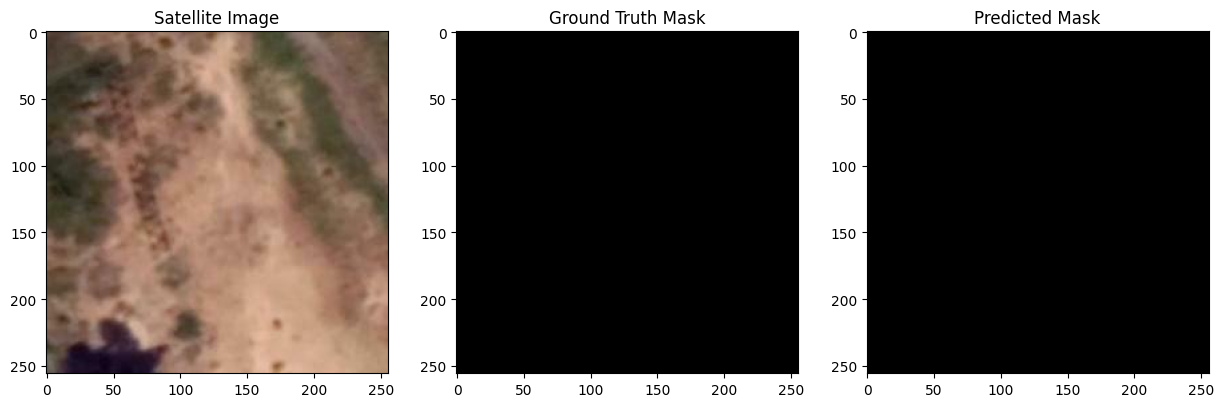

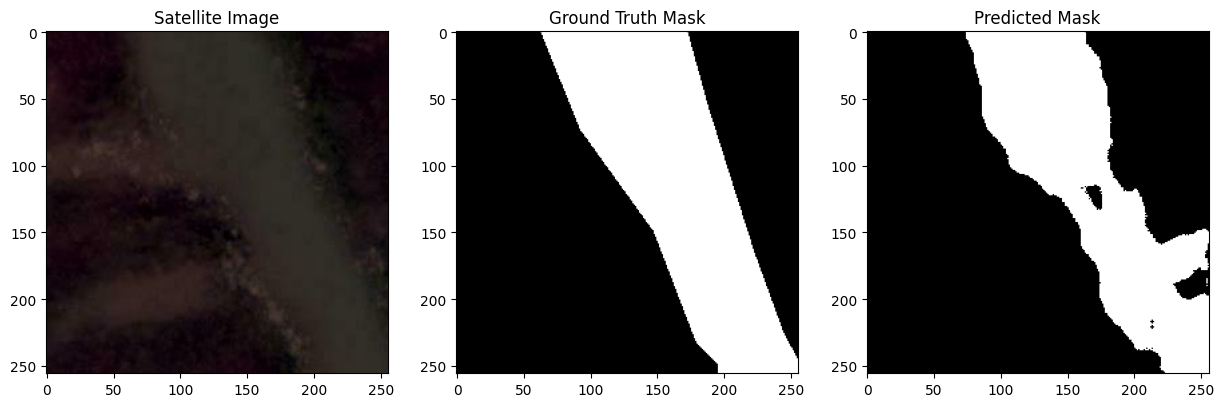

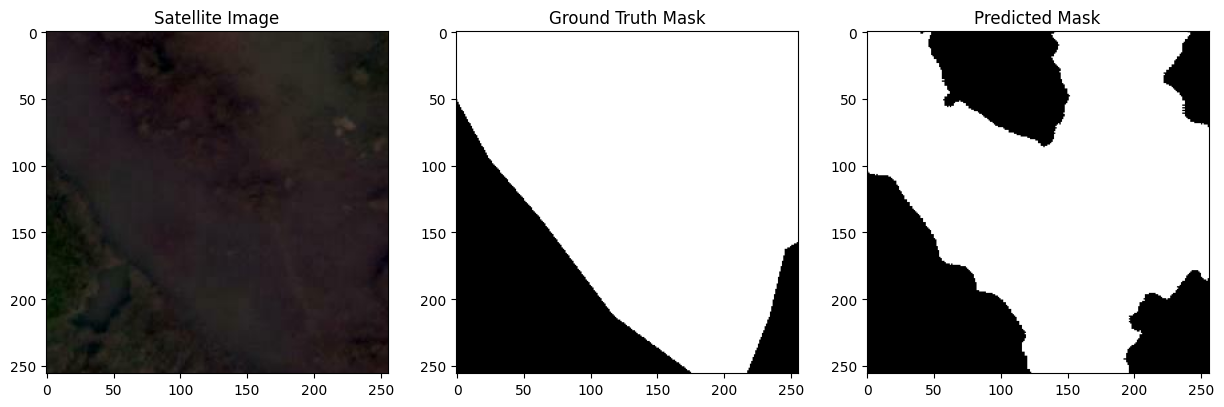

In [ ]:
def get_predictions(dataset, num_batches):
    images = []
    masks = []
    preds = []
    for image_batch, mask_batch in dataset.take(num_batches):
        preds_batch = model.predict(image_batch)
        images.append(image_batch)
        masks.append(mask_batch)
        preds.append(preds_batch)
    images = tf.concat(images, axis=0)
    masks = tf.concat(masks, axis=0)
    preds = tf.concat(preds, axis=0)
    return images, masks, preds

NUM_BATCHES = 5
val_images, val_masks, val_preds = get_predictions(val_dataset, NUM_BATCHES)

val_preds_threshold = tf.cast(val_preds > 0.5, tf.uint8)

NUM_SAMPLES = 10

for idx in range(NUM_SAMPLES):
    plt.figure(figsize=(15, 5))

    plt.subplot(1, 3, 1)
    plt.imshow(val_images[idx])
    plt.title('Satellite Image')

    plt.subplot(1, 3, 2)
    plt.imshow(tf.squeeze(val_masks[idx]), cmap='gray')
    plt.title('Ground Truth Mask')

    plt.subplot(1, 3, 3)
    plt.imshow(tf.squeeze(val_preds_threshold[idx]), cmap='gray')
    plt.title('Predicted Mask')

    plt.show()


In [ ]:
def iou_coef(y_true, y_pred, smooth=1):
    y_true_f = tf.reshape(y_true, [-1])
    y_pred_f = tf.cast(tf.reshape(y_pred, [-1]), tf.float32)
    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    union = tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f) - intersection
    iou = (intersection + smooth) / (union + smooth)
    return iou


ious = []
for i in range(len(val_images)):
    iou = iou_coef(val_masks[i], val_preds_threshold[i])
    ious.append(iou.numpy())

mean_iou = np.mean(ious)
print(f"Mean IoU on validation set: {mean_iou}")


Mean IoU on validation set: 0.6900510787963867


In [ ]:
model.save('water_segmentation_unet.keras')


In [ ]:
test_dataset = test_image_files.map(lambda x: tf.io.read_file(x))
test_dataset = test_dataset.map(lambda x: tf.image.decode_png(x, channels=IMG_CHANNELS))
test_dataset = test_dataset.map(lambda x: tf.image.resize(x, [IMG_HEIGHT, IMG_WIDTH]))
test_dataset = test_dataset.map(lambda x: x / 255.0)
test_dataset = test_dataset.batch(BATCH_SIZE)
test_dataset = test_dataset.prefetch(AUTOTUNE)


test_preds = model.predict(test_dataset, verbose=1)
test_preds_threshold = (test_preds > 0.5).astype(np.uint8)


test_images = []
for image_batch in test_dataset.take(1):
    test_images.append(image_batch)
test_images = tf.concat(test_images, axis=0)

NUM_SAMPLES = 5

for idx in range(NUM_SAMPLES):
    plt.figure(figsize=(10, 5))

    plt.subplot(1, 2, 1)
    plt.imshow(test_images[idx])
    plt.title('Test Satellite Image')

    plt.subplot(1, 2, 2)
    plt.imshow(tf.squeeze(test_preds_threshold[idx]), cmap='gray')
    plt.title('Predicted Mask')

    plt.show()


In [ ]:
from google.colab import files
files.download('water_segmentation_unet.keras')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>